# The Transformation and Accept/Reject (aka. Von Neumann) methods 
Python notebook with exercise on how to generate random numbers following a specific PDF using uniformly distributed random numbers, in this case three different functions, each with their own challenge.

Both the Accept-Reject (Von Neumann) and transformation method should be considered for the problem (or a combination of both!):
- Transformation method (if function can be integrated and then inverted).
- Accept-Reject (or Hit & Miss) method (by Ulam Stanislav and John Von Neumann).

### References:
- G. Cowan: Chapter 3
- P. R. Bevington: page 81-84
- __[40. Monte Carlo Techniques PDG](http://pdg.lbl.gov/2020/reviews/rpp2020-rev-monte-carlo-techniques.pdf)__

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 29-11-2022 (latest update)

***

In [118]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

Load external functions:

In [119]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

Set the parameters of the program:

In [120]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 10000    # Number of random points to be generated

## Problem 1: 

#### Produce random points following $f(x) \sim \exp(-x/3), x \in [0, \infty]$.

## Normalizing yields

$f(x) = 1/3 \exp(-x/3)$

## The inverted cumulative function is given by

$x(r) = -3 \ln ( 1 - r),  r \in [0, \infty)$

## since 

$P(x<25) = \int_0^{25} f(x) dx = 1 - \exp(-25/3)  = 0.9998$, 

$xmax = 25$ is a reasonable upper limit

In [121]:
# Define a reasonable range to plot in:
xmin = 0
xmax = 25
N_bins = 100

x_transformation = - 3 * np.log (1 - r.rand(N_points))


# Using a constant probability distribution will be very inefficient.  Instead, 

## ALGORITHM: The goal is to x1, ...., xn points distributed according to f on domain D
# 1) generate a point x in D distributed according to a probability distribution g enclosing f, ie f <= g on D
# 2) generate uniformly a random point u in [0,g(x)]
# 3) if u<f(x), keep x. 
# 4) Rinse and repeat until desired number of points has been aquired

# Construct transformation values in accordance with problem 1) and 2)
def pdf_1(x):
    return  1/3 * np.exp(- x / 3)

x_accepted = np.empty(1)
N_try = int(2 * N_points)
N_accum = N_try

while x_accepted.size < N_points:
    # Construct N_points points by accepting/rejecting without the horrible while loop

    ## First, we construct N_try points uniformly on [xmin,xmax]
    r_vals = xmin + (xmax - xmin) * r.rand(N_try)
    ## Next, we construct another set of uniform random values in [0,fmax = 1/3]
    u_vals = 1/3 * r.rand(N_try)
    ## Finally, we keep only the r_vals values satisfying u_vals < fx_x3 (r_vals)
    mask = (u_vals < pdf_1(r_vals))

    x_accepted = np.r_['0', x_accepted, r_vals[mask]]

    N_try = int(3 * (N_points - x_accepted.size))
    N_accum += N_try

    if x_accepted.size > N_points:
        x_accepted = x_accepted[:N_points]

efficiency = N_points / N_accum
eff_err = np.sqrt(efficiency*(1-efficiency) / N_accum)
print("efficiency: ", f'{efficiency:6.3f}', "\u00B1 ", f'{eff_err:6.3f}')


efficiency:   0.118 ±   0.001


And to make sure that we have computed the points correctly, we plot a histogram of the data:

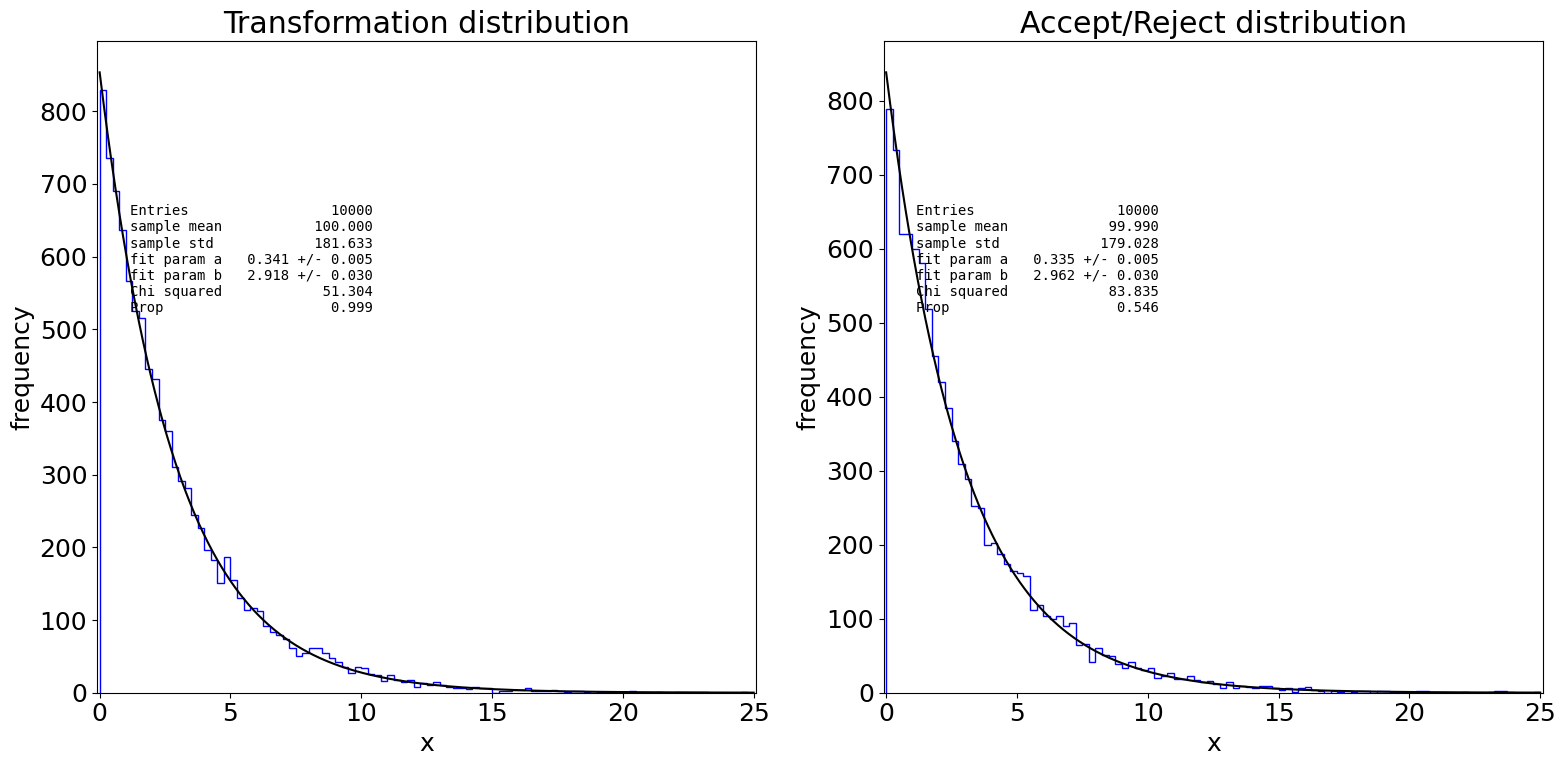

In [122]:
## Fit both distributions

def fit_func (x, a, b):
     # Scale function
    bin_width = (xmax - xmin) / N_bins
    scaling = N_points * bin_width
    return scaling * a * np.exp(- x / b)

fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
ax = ax.flatten()

values = [x_transformation, x_accepted]
names = ['Transformation distribution', 'Accept/Reject distribution']

for i, val in enumerate(values):
    counts, edges, _ = ax[i].hist(val, range = (xmin, xmax), bins = N_bins, histtype = 'step', color = 'blue')
    ax[i].set(xlim = (xmin-0.1,xmax+0.1), ylabel = f'frequency', xlabel = 'x', title = names[i])

    x_vals = 0.5 * ( edges[:-1] + edges[1:])
    y_vals = counts
    y_err = np.sqrt(counts)
    mask = (y_vals > 0)
    N_non_empty = len(mask)

    chi2_object = Chi2Regression(fit_func, x_vals[mask], y_vals[mask], y_err[mask])
    chi2_object.errordef = 1

    fit = Minuit(chi2_object, a = 0.33, b = 3)
    fit.migrad()

    # Plot fit
    x_range = np.linspace(xmin, xmax, 1000)

   
    scaling = 1
    fit_vals =  fit_func(x_range, *fit.values[:])

    ax[i].plot(x_range, fit_vals, 'k-')

    # Get statistics
    Ndof = len(y_vals[mask])
    chi2 = fit.fval
    prop = stats.chi2.sf(chi2, Ndof)
    d = {"Entries": N_points, "sample mean ": y_vals.mean(), "sample std ": y_vals.std(ddof = 1), "fit param a": [fit.values['a'],fit.errors['a']] ,
            "fit param b": [fit.values['b'],fit.errors['b']], "Chi squared": chi2, "Prop": prop}

    # Plot figure text
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.75, text, ax[i], fontsize=10)


    fig.tight_layout()

## Problem 2: 

#### Produce random points following $g(x) \sim x \cos(x), x \in [0, \frac{\pi}{2}]$.

In [123]:
xmin, xmax = 0, np.pi/2         # Note the simple/short notation.

## Using rejection/accepting method 
x_accepted = np.empty(1)
N_try = int(2 * N_points)
N_accum = N_try

# Define pdf
def pdf_2(x):
    return x * np.cos(x)

# find max value of g by fixed point iteration of the derivative x*cos(x)
y0 = 1.0
y = 2.0
max_it = 100
it = 0

while np.abs(y-y0) > 1e-3 and it < max_it:
    it += 1
    if it == max_it:
        print("not converged")
    y = y0 * np.cos(y0)
    y0 = y

while x_accepted.size < N_points:
    # Construct N_points points by accepting/rejecting without the horrible while loop

    ## First, we construct N_try points uniformly on [xmin,xmax]
    r_vals = xmin + (xmax - xmin) * r.rand(N_try)
    ## Next, we construct another set of uniform random values in [0,fmax = y]
    u_vals = y * r.rand(N_try)
    ## Finally, we keep only the r_vals values satisfying u_vals < fx_x3 (r_vals)
    mask = (u_vals < pdf_2(r_vals))

    x_accepted = np.r_['0', x_accepted, r_vals[mask]]

    N_try = int(3 * (N_points - x_accepted.size))
    N_accum += N_try

    if x_accepted.size > N_points:
        x_accepted = x_accepted[:N_points]

efficiency = N_points / N_accum
eff_err = np.sqrt(efficiency*(1-efficiency) / N_accum)
print("efficiency: ", f'{efficiency:6.3f}', "\u00B1 ", f'{eff_err:6.3f}')

efficiency:   1.020 ±     nan


C:\Users\Simon\AppData\Local\Temp\ipykernel_12952\2162296327.py:44: RuntimeWarning: invalid value encountered in sqrt
  eff_err = np.sqrt(efficiency*(1-efficiency) / N_accum)


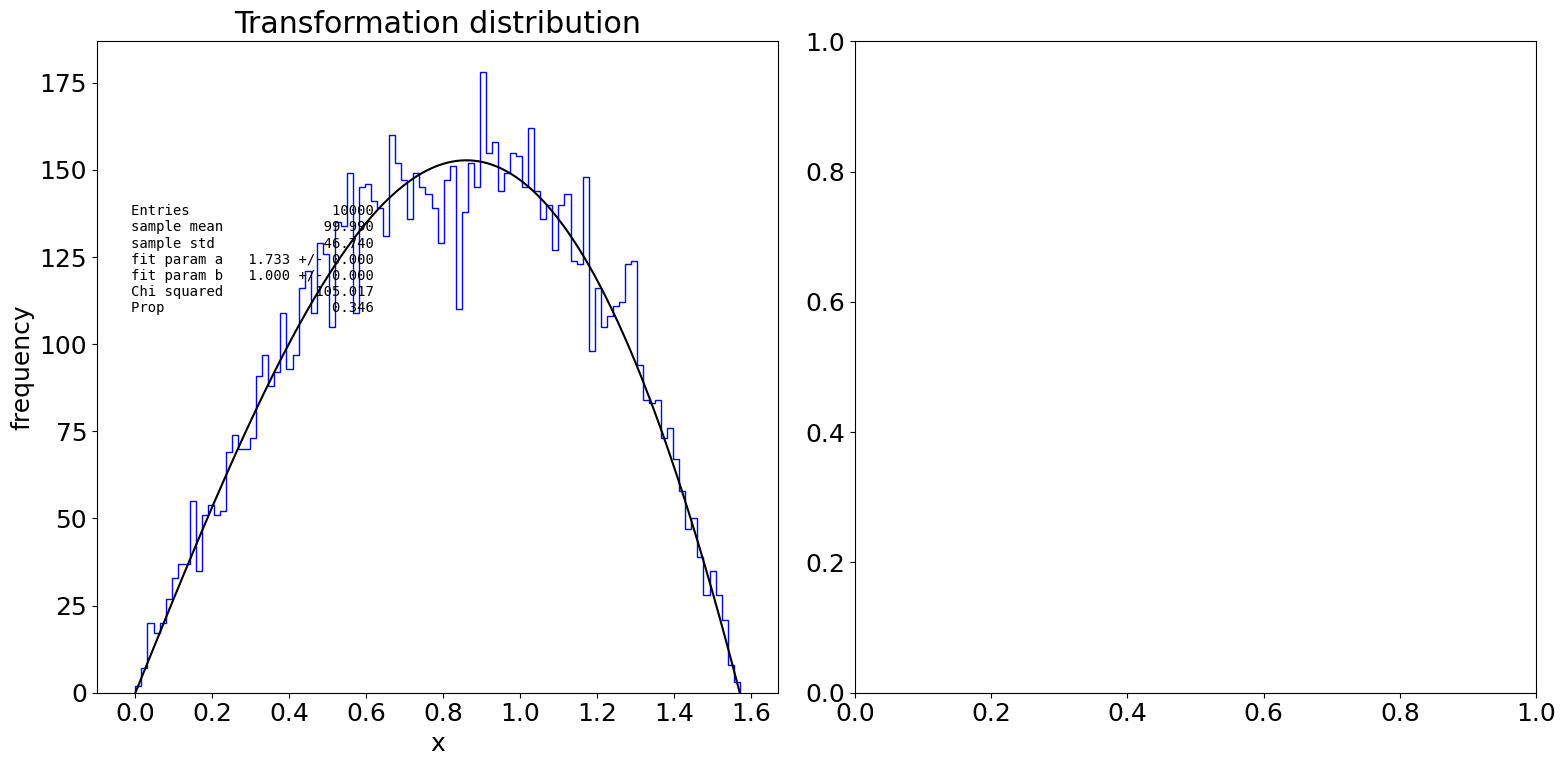

In [124]:
## Fit both distributions

def fit_func (x, a, b):
     # Scale function
    bin_width = (xmax - xmin) / N_bins
    scaling = N_points * bin_width
    return scaling * a * x * np.cos(x)
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
ax = ax.flatten()

values = [x_accepted]
names = ['Transformation distribution', 'Accept/Reject distribution']

for i, val in enumerate(values):
    counts, edges, _ = ax[i].hist(val, range = (xmin, xmax), bins = N_bins, histtype = 'step', color = 'blue')
    ax[i].set(xlim = (xmin-0.1,xmax+0.1), ylabel = f'frequency', xlabel = 'x', title = names[i])

    x_vals = 0.5 * ( edges[:-1] + edges[1:])
    y_vals = counts
    y_err = np.sqrt(counts)
    mask = (y_vals > 0)
    N_non_empty = len(mask)

    chi2_object = Chi2Regression(fit_func, x_vals[mask], y_vals[mask], y_err[mask])
    chi2_object.errordef = 1

    fit = Minuit(chi2_object, a = 1, b = 1)
    fit.migrad()

    # Plot fit
    x_range = np.linspace(xmin, xmax, 1000)

   
    scaling = 1
    fit_vals =  fit_func(x_range, *fit.values[:])

    ax[i].plot(x_range, fit_vals, 'k-')

    # Get statistics
    Ndof = len(y_vals[mask])
    chi2 = fit.fval
    prop = stats.chi2.sf(chi2, Ndof)
    d = {"Entries": N_points, "sample mean ": y_vals.mean(), "sample std ": y_vals.std(ddof = 1), "fit param a": [fit.values['a'],fit.errors['a']] ,
            "fit param b": [fit.values['b'],fit.errors['b']], "Chi squared": chi2, "Prop": prop}

    # Plot figure text
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.75, text, ax[i], fontsize=10)


    fig.tight_layout()

## Problem 3: 

#### Produce random points following $h(x) \sim \exp(-x/3)\cos(x)^2$ in the interval $[0, \infty]$ and estimate the integral of $h(x)$ in the defined range.

xmax = 25 is reasonable since $P(x<25) = 0.9997$. The cumulative distribution function is not invertible, and rejection/accepting scheme must be used.

The normalization constant = 37/57, found numerically

In [132]:
xmin, xmax = 0, 35      # Note the simple/short notation.
N_points = 100000


## ALGORITHM: The goal is to x1, ...., xn points distributed according to f on domain D
# 1) generate a point x in D distributed according to a probability distribution g/area(g) (so g can be any curve...) enclosing f, ie f <= g on D
# 2) generate uniformly a random point u in [0,g(x)]
# 3) if u<f(x), keep x. 
# 4) Rinse and repeat until desired number of points has been aquired


## Using rejection/accepting method with both a constant pdf as well as 1/(1+x)
x_accepted = np.empty(1)
x_accepted_non_uniform = np.empty(1)
N_try = int(2 * N_points)
N_accum = N_try
N_accum_non_uniform = N_try
y_max = 37/57
# area of g from [0,25]
g_area = np.log(1 + xmax)
# Define pdf
def pdf_3(x):
    return 37 / 57 * np.exp(-x/3) * np.cos(x)**2
def g(x):
    return 1/(1+x)

while x_accepted.size < N_points or x_accepted_non_uniform.size < N_points:
    # Construct N_points points by accepting/rejecting using a uniform pdf
    ## First, we construct N_try points uniformly on [xmin,xmax]
    r_vals = xmin + (xmax - xmin) * r.rand(N_try)
    ## Next, we construct another set of uniform random values in [0,fmax = y]
    u_vals = y_max * r.rand(N_try)
    ## Finally, we keep only the r_vals values satisfying u_vals < fx_x3 (r_vals)
    mask = (u_vals < pdf_3(r_vals))
    x_accepted = np.r_['0', x_accepted, r_vals[mask]]

    ## Construct N_points using the pdf g(x)/g_area = 1/(1+x) /g_area, which satisfies g>pdf_3 for all x in [0,25]
    # the inverse cumulative dist function of g is x(r) = exp(r * g_area) - 1
    # generate N_try values according to g/normalization(g)
    r_vals = (np.exp(g_area * r.rand(N_try)) - 1) 
    # generate N_try values uniformly from 0 to g(x)
    u_vals =  g(r_vals) * r.rand(N_try)

    # accept r values satisfying u < f(x)
    mask = (u_vals < pdf_3(r_vals))
    x_accepted_non_uniform = np.r_['0', x_accepted_non_uniform, r_vals[mask]]

    N_try = int(3 * (N_points - x_accepted.size))

   

    if x_accepted.size > N_points:
        x_accepted = x_accepted[:N_points]
    elif x_accepted.size < N_points:
         N_accum += N_try
    if x_accepted_non_uniform.size > N_points:
        x_accepted_non_uniform = x_accepted_non_uniform[:N_points]
    elif x_accepted_non_uniform.size < N_points:
        N_accum_non_uniform += N_try

eff_uni = N_points / N_accum
eff_non_uni = N_points / N_accum_non_uniform
eff_err = np.sqrt(eff_uni*(1-eff_uni) / N_accum)
eff_err_non_uni = np.sqrt(eff_non_uni*(1-eff_non_uni) / N_accum)

integral = eff_uni * (xmax-xmin) * (y_max - 0)
int_err = eff_err * (xmax-xmin) * (y_max - 0)

print("integral from [0,25] ~ [0,inf]: ", f'{integral:.3f}', "\u00B1", f'{int_err:.3f}')
print("efficiency uniform: ", f'{eff_uni:6.3f}', "\u00B1 ", f'{eff_err:6.3f}')
print("efficiency non_uniform: ", f'{eff_non_uni:6.3f}', "\u00B1 ", f'{eff_err_non_uni:6.3f}')

integral from [0,25] ~ [0,inf]:  1.000 ± 0.003
efficiency uniform:   0.044 ±   0.000
efficiency non_uniform:   0.211 ±   0.000


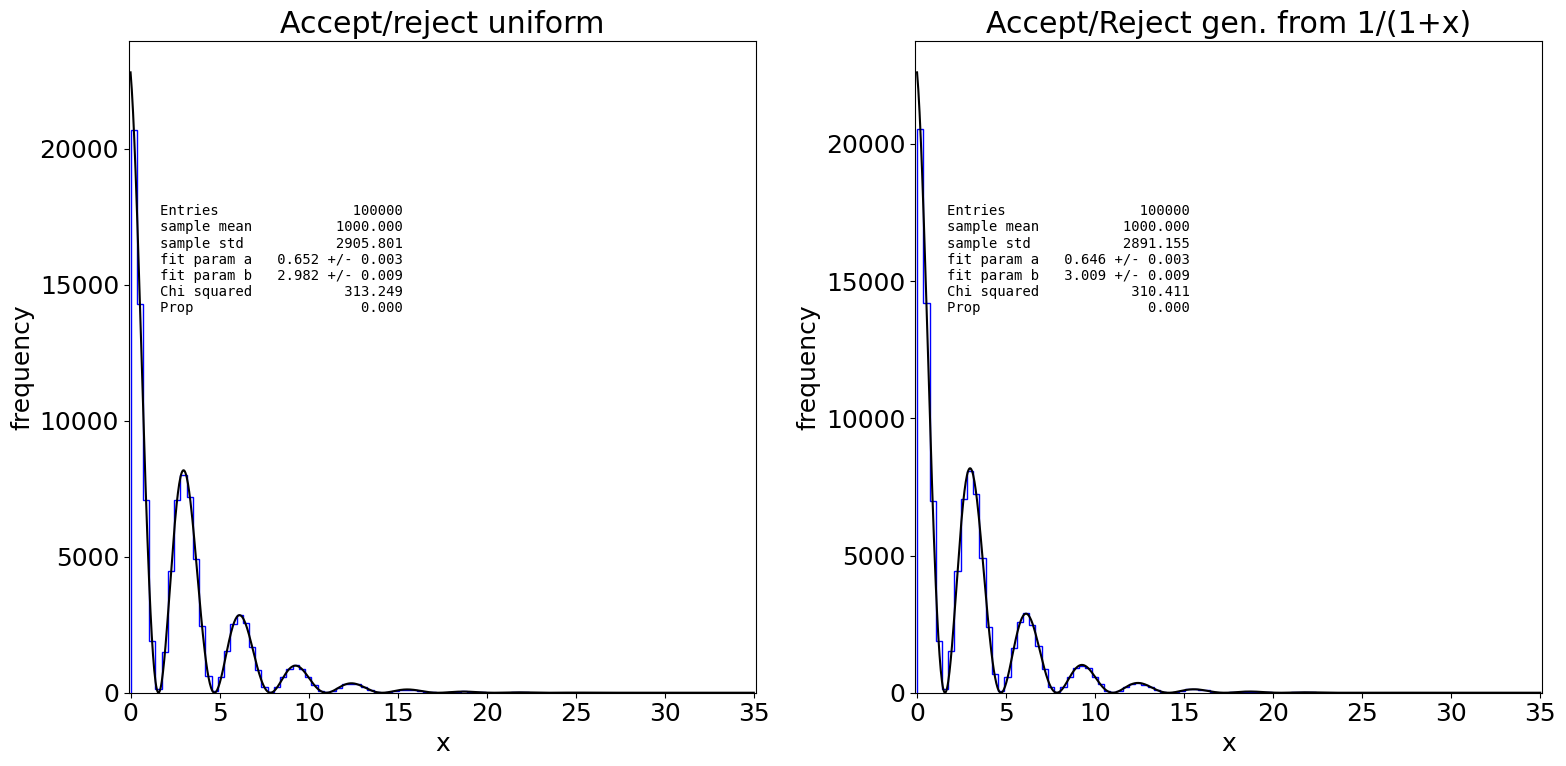

In [133]:
def fit_func (x, a, b):
     # Scale function
    bin_width = (xmax - xmin) / N_bins
    scaling = N_points * bin_width
    return scaling * a * np.exp(-x/b) * np.cos( x) ** 2
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
ax = ax.flatten()

values = [x_accepted, x_accepted_non_uniform]
names = ['Accept/reject uniform', 'Accept/Reject gen. from 1/(1+x)']

for i, val in enumerate(values):
    counts, edges, _ = ax[i].hist(val, range = (xmin, xmax), bins = N_bins, histtype = 'step', color = 'blue')
    ax[i].set(xlim = (xmin-0.1,xmax+0.1), ylabel = f'frequency', xlabel = 'x', title = names[i])

    x_vals = 0.5 * ( edges[:-1] + edges[1:])
    y_vals = counts
    y_err = np.sqrt(counts)
    mask = (y_vals > 0)
    N_non_empty = len(mask)

    chi2_object = Chi2Regression(fit_func, x_vals[mask], y_vals[mask], y_err[mask])
    chi2_object.errordef = 1

    fit = Minuit(chi2_object, a = 0.6, b = 3)
    fit.migrad()

    # Plot fit
    x_range = np.linspace(xmin, xmax, 1000)

   
    scaling = 1
    fit_vals =  fit_func(x_range, *fit.values[:])

    ax[i].plot(x_range, fit_vals, 'k-')

    # Get statistics
    Ndof = len(y_vals[mask])
    chi2 = fit.fval
    prop = stats.chi2.sf(chi2, Ndof)
    d = {"Entries": N_points, "sample mean ": y_vals.mean(), "sample std ": y_vals.std(ddof = 1), "fit param a": [fit.values['a'],fit.errors['a']] ,
            "fit param b": [fit.values['b'],fit.errors['b']], "Chi squared": chi2, "Prop": prop}

    # Plot figure text
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.75, text, ax[i], fontsize=10)


    fig.tight_layout()

# Learning points:

While you should by now be able to solve problem 1+2 with at least one of the methods, problem 3 is harder, and requires the combination of the two. Solving this exercise should make you:
1. "proficient" in using the two standard methods.
2. capable of getting random numbers according to ALL 1D PDFs, bounded/integrable/invertible or not.

The last point of problem 3 should also illustrate, how you can estimate integrals using this method.